# Low-Rank and Linear Spectral Matrix Completion for Playlist Recommendation

In [1]:
# -*- coding: utf8 -*-
import sys
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse
import itertools
import IPython.utils.path

# Customize plot colors for dark backgrounds
%matplotlib inline
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['grid.color'] = '#66CCCC'
mpl.rcParams['text.color'] = '#0EBFE9'
mpl.rcParams['xtick.color'] = '#66CCCC'
mpl.rcParams['ytick.color'] = '#66CCCC'
mpl.rcParams['axes.labelcolor'] = '#0EBFE9'

import recog as rec

%load_ext autoreload
%autoreload 2

# reload(sys)  # Reload does the trick!
# sys.setdefaultencoding('UTF8')

# pd.options.display.encoding = 'utf-8'

## Test on synthetic data

In [295]:
DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'work/recog/resources/')
print 'Data directory:', DATA_DIR
dataset_name = 'recom'

Data directory: /Users/kikohs/work/recog/resources/


In [296]:
data = sp.io.loadmat(os.path.join(DATA_DIR, 'recom_data.mat'))

In [300]:
data['C'].shape

(256, 128)

### Description

- A_gt = A ground truth
- B_gt = B ground truth
- C = ground truth
- A init = Initialisation A because the problem is non convex
- B init = Initialisation B
- KA, KB = graph gradient operators for A, B
- O = Omega = observation mask
- WB = graph of B (songs)
- perc: percentage of observation
- norm A: norm of operator A


In [82]:
A, B = rec.proximal_training(data['C'], data['WA'], data['WB'], 
                             data['Agt'].shape[1], data['O'], nb_iter_max=100, verbose=False)

Converged in 55 steps, reconstruction error: 0.268964608707
Total elapsed time: 16.6595849991 seconds


### Plot results

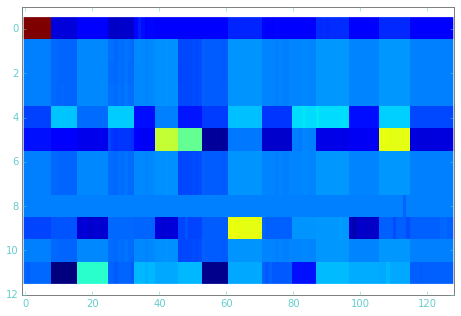

In [83]:
rec.plot_factor_mat(B)

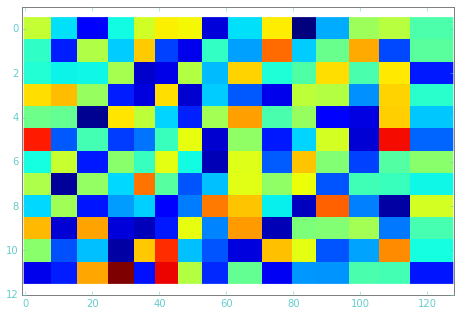

In [84]:
rec.plot_factor_mat(data['Bgt'])

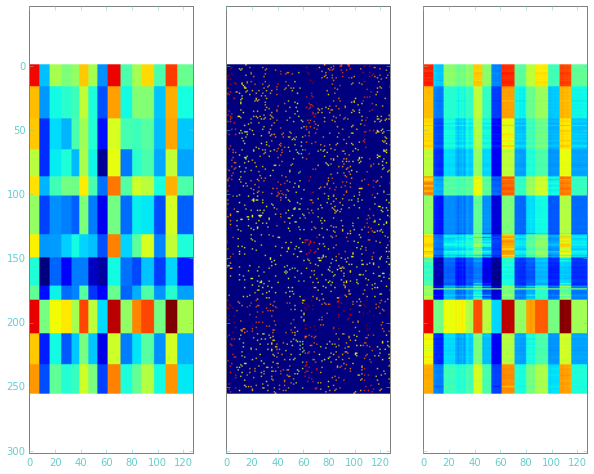

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches((10, 8))
ax1.imshow(data['C'])
ax2.imshow(data['C'] * data['O'])
ax3.imshow(A.dot(B))

### Recommender part

In [220]:
results = sp.io.loadmat(os.path.join(DATA_DIR, 'result_AB.mat'))

In [ ]:
def keypoint_test(C, obs=0.05, row=15):
    # TODO
#     if not given rand
    c_test = C[row, :]
    to_pick = int(len(c_test) * obs)
    mask = np.random.choice(range(len(c_test)), to_pick)    
    return zip(mask, c_test[mask])
                                     
    
row = 15
c_test = keypoint_test(data['C'], row=row)
c_reco = rec.recommend(B, c_test)

np.linalg.norm(data['C'][row, :] - c_reco)

In [221]:
def keypoint_test(C, obs=0.05, row=15):
    # TODO
#     if not given rand
    c_test = C[row, :]
    to_pick = int(len(c_test) * obs)
    mask = np.random.choice(range(len(c_test)), to_pick)    
    return zip(mask, c_test[mask])
                                     
    
row = 15
c_test = keypoint_test(data['C'], row=row)
_, c_reco = rec.recommend(results['B'], c_test, 0)

np.linalg.norm(data['C'][row, :] - c_reco)

0.017708517408966035

In [240]:
results['B']

array([[ 0.09001966,  0.09001964,  0.09001966, ...,  0.08731969,
         0.08712971,  0.08712971],
       [ 0.07630951,  0.07630951,  0.07630951, ...,  0.07589075,
         0.07589075,  0.07589075],
       [ 0.08990648,  0.08990646,  0.08990647, ...,  0.08731734,
         0.08712668,  0.08712668],
       ..., 
       [ 0.08892649,  0.08892649,  0.08892653, ...,  0.08892642,
         0.08892642,  0.08892642],
       [ 0.08624339,  0.0862434 ,  0.0862434 , ...,  0.0862434 ,
         0.08624339,  0.0862434 ],
       [ 0.0900008 ,  0.09000078,  0.0900008 , ...,  0.08735646,
         0.08735646,  0.08735646]])

In [227]:
print results['A'].shape
print results['B'].shape

(256, 12)
(12, 128)


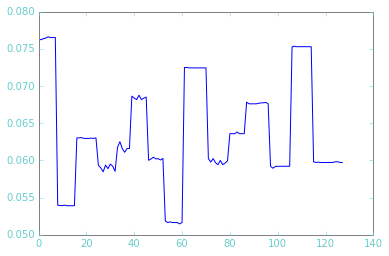

In [222]:
plt.plot(c_reco)

In [224]:
c_test

[(57, 0.051763861750000265),
 (0, 0.076637479611519704),
 (53, 0.051763861750000265),
 (19, 0.062980725298801846),
 (39, 0.068752175343886862),
 (89, 0.067845287201278554)]

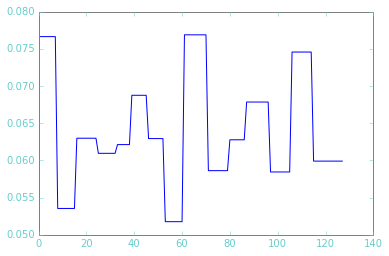

In [18]:
plt.plot(data['C'][row, :])

## Test on real data

In [2]:
# DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'data/aotm/')
DATA_DIR = os.path.join( IPython.utils.path.get_home_dir(), 'local/aotm/')
print 'Data directory:', DATA_DIR

DATASET_NAME = 'aotm'
MAX_PROCESS = 8

Data directory: /Users/kikohs/local/aotm/


In [3]:
SONGS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_songs.h5'), 'data')
SONGS.rename(columns={'temporal_echonest_features': 'ten'}, inplace=True)
PLAYLISTS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_playlists.h5'), 'data')

MIXES = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_mixes.h5'), 'data')
# MIXES = MIXES.set_index('mix_id').rename(columns={'aotm_ids':'aotm_id'})
# MIXES['size'] = MIXES[song_id_key].apply(len)
# MIXES.to_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_mixes.h5'), 'data')

song_id_key = 'aotm_id'
playlist_id_key = 'mix_id'

In [4]:
# Extract features only from data
to_remove = set(['artist_name', 'genre', 'top_genres', 'terms', 'release', 'key', 'mode', 'genre_topics'])
columns = set(SONGS.columns.tolist())

feat_col = list(columns - to_remove)
FEAT = SONGS[feat_col]

### Create smaller dataset from AOTM data

Mainly to test the algorithm in a real case.

In [5]:
FILT_MIXES = MIXES[~MIXES.playlist_category.isin(['Mixed Genre', 'Theme', 'Single Artist'])]
FILT_MIXES = FILT_MIXES[FILT_MIXES['size'] > 10]

FILT_PLAYLISTS = PLAYLISTS[PLAYLISTS[playlist_id_key].isin(FILT_MIXES.index)]

# # Keep only valid song and features
all_songs = pd.unique(FILT_PLAYLISTS[song_id_key])
FILT_SONGS = SONGS[SONGS.index.isin(all_songs)]
FILT_FEAT = FEAT[FEAT.index.isin(all_songs)]

SONG_TO_IDX = dict(zip(FILT_SONGS.index.values, itertools.count()))

In [6]:
start = time.time()
FILT_SONG_GRAPH = rec.create_song_graph(FILT_FEAT, 10, FILT_SONGS[['artist_name', 'genre']], relabel_nodes=True)
print 'Created in:', time.time() - start
print nx.info(FILT_SONG_GRAPH)

Created in: 2.12711501122
Name: Song graph
Type: Graph
Number of nodes: 2167
Number of edges: 17821
Average degree:  16.4476


In [7]:
start = time.time()
FILT_PLAYLIST_GRAPH = rec.create_playlist_graph(FILT_MIXES, FILT_PLAYLISTS, 
                                            playlist_id_key, song_id_key, 'playlist_category', relabel_nodes=True)
print 'Created in:', time.time() - start
print nx.info(FILT_PLAYLIST_GRAPH)

Created in: 0.413201808929
Name: Playlist graph
Type: Graph
Number of nodes: 190
Number of edges: 2028
Average degree:  21.3474


In [8]:
C = rec.create_recommendation_matrix(FILT_MIXES, FILT_SONGS.index, 
                                     playlist_id_key, DATASET_NAME, normalize=True)

### Train model

In [10]:
rank = 20
theta_tv = 5e-4
A, B = rec.proximal_training(C, FILT_PLAYLIST_GRAPH, FILT_SONG_GRAPH, rank, 
                             theta_tv=theta_tv, verbose=True)

Step: 1 , err: 4.16298067337
Delta A: 4.29245353137
Step: 2 , err: 4.01996690428
Delta A: 0.850462568809
Step: 3 , err: 4.01884035221
Delta A: 0.0161714455621
Step: 4 , err: 4.0188156164
Delta A: 0.00102619977726
Converged in 4 steps, reconstruction error: 4.0188156164
Total elapsed time: 50.6340711117 seconds


### Recommender part

In [11]:
np.unique(FILT_MIXES['playlist_category']).tolist()

['Alternating DJ',
 'Blues',
 'Break Up',
 'Country',
 'Cover',
 'Dance/House',
 'Electronic Music',
 'Experimental',
 'Folk',
 'Goth',
 'Hardcore',
 'Hip Hop',
 'Indie',
 'Indie Rock',
 'Jazz',
 'Mixed',
 'Narrative',
 'Punk',
 'Reggae',
 'Rhythm and Blues',
 'Road Trip',
 'Rock/Pop',
 'Romantic',
 'Skate/Thrash',
 'Sleep',
 'Techno',
 'World Music']

In [15]:
def pick_playlist_category(mix_df, category_key='playlist_category'):
    return np.random.choice(np.unique(mix_df[category_key]))


def pick_random_sample(playlist_df, category, sample_size, song_id_key, category_key='playlist_category'):
    subset = playlist_df[playlist_df[category_key] == category]
    
    assert(len(subset) > 0)
    assert(sample_size > 0)
    
    if sample_size > len(subset):
        sample_size = len(subset)
    
    return np.random.choice(subset[song_id_key].values, sample_size)
    

def pick_random_sample_genre(song_df, genre, sample_size):
    subset = song_df[song_df['genre'] == genre]
    assert(len(subset) > 0)
    assert(sample_size > 0)
    
    if sample_size > len(subset):
        sample_size = len(subset)
    
    return np.random.choice(subset.index.values, sample_size)
    
    
sample_size = 10
category = pick_playlist_category(FILT_MIXES)
picked_song_ids = pick_random_sample(FILT_PLAYLISTS, category, sample_size, song_id_key)
keypoints = zip(picked_song_ids, np.ones(len(picked_song_ids)))

In [52]:
genre = 'Pop'
picked_song_ids = pick_random_sample_genre(FILT_SONGS, genre, sample_size)
keypoints = zip(picked_song_ids, np.ones(len(picked_song_ids)))

In [53]:
k = 30
reco_idx, raw = rec.recommend(B, keypoints, k, SONG_TO_IDX)
REC_SONGS = FILT_SONGS.iloc[reco_idx]

In [54]:
# print 'Chosen playlist category:', category
REC_SONGS['genre'].value_counts()

Folk                5
Electronic          5
Alternative         4
Rock                3
Heavy Metal         2
Country             2
Classic Rock        1
Psychedelic Rock    1
Easy Listening      1
Avantgarde          1
Punk                1
Jazz                1
Dance               1
Grunge              1
Death Metal         1
dtype: int64

In [43]:
# FILT_SONGS['genre'].value_counts()